## Imports and setup

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

from matplotlib.colors import hsv_to_rgb
import colorsys

In [2]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

## Load img

In [3]:
path = 'wall_pics/wall1.png'
img = cv.imread(path, cv.IMREAD_UNCHANGED)
orig = img.copy()
RGB_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

## Look at original image

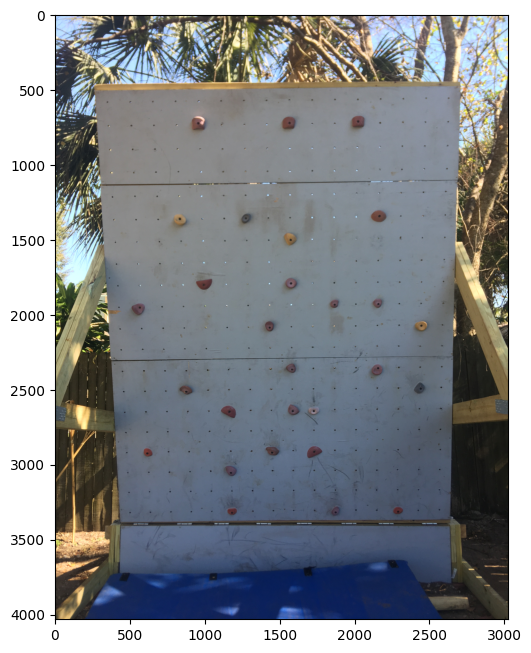

In [4]:
plt.imshow(RGB_img)

---
# Attempt to identify corners of images directly

## Apply bilateral filter to smooth out image

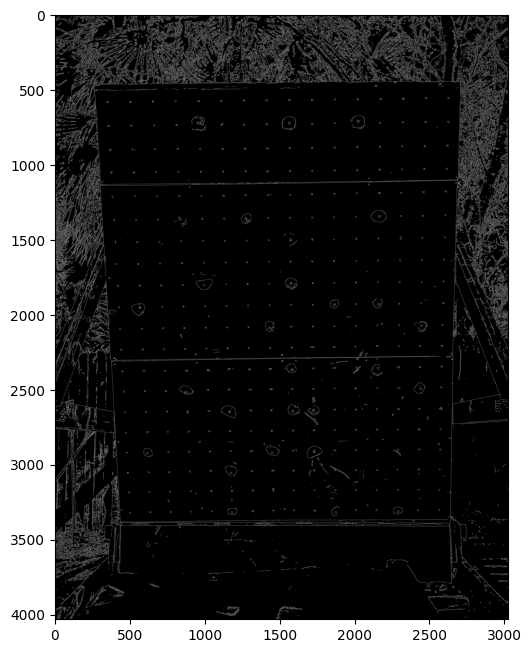

In [5]:
img_blur = cv.bilateralFilter(gray, 11, 17, 17)
low_thresh = 30
hi_thresh = 25
# ratio = 10
# hi_thresh = low_thresh * ratio
edged = cv.Canny(img_blur, low_thresh, hi_thresh)

plt.imshow(edged, cmap='gray')

## Get threshold image (don't remember why this helps)

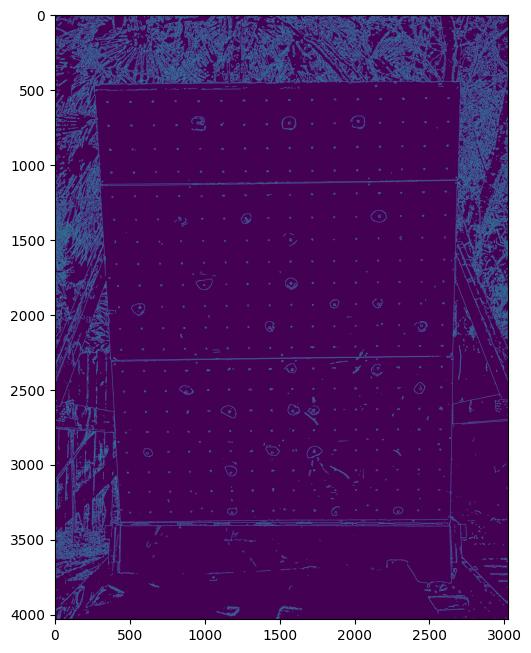

In [6]:
img_grey = edged
#set a thresh
thresh = 100
#get threshold image
ret,thresh_img = cv.threshold(img_grey, thresh, 255, cv.THRESH_BINARY)
# display thresh img
plt.imshow(thresh_img)

## Find contours in image

In [7]:
# inp = edged
inp = thresh_img

#find contours
contours, hierarchy = cv.findContours(inp, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

#create an empty image for contours
img_contours = np.zeros(img.shape, dtype=np.uint8)

(4032, 3024, 3)


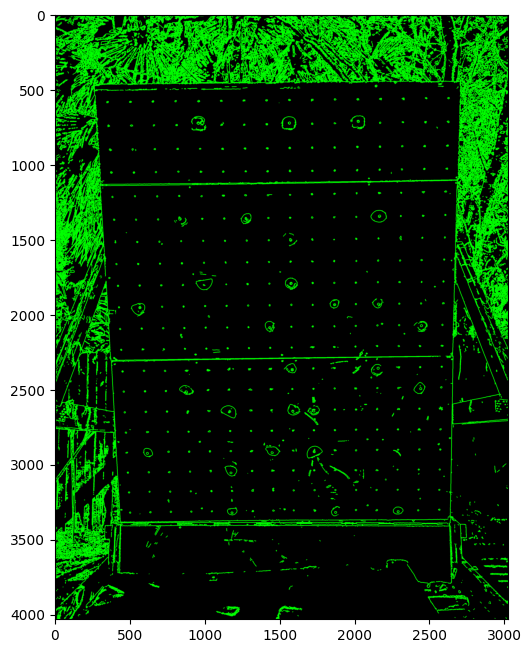

In [8]:
# draw the contours on the empty image
cv.drawContours(img_contours, contours, -1, (0,255,0), 3)
plt.imshow(img_contours)
print(img_contours.shape)

## Explore contours

In [9]:
# num_pts_per_cnt = [cnt.shape[0] for cnt in contours]
# num_pts_per_cnt.sort()
# plt.plot(num_pts_per_cnt)

In [10]:
# # get strongest contours
# num = 500
# strongest_contours = sorted(contours, key=cv.contourArea, reverse=True)[:num]

In [11]:
# upper = 1000000
# lower = 200
# img_cnts = np.zeros(orig.shape, dtype=np.uint8)

# for cnt in contours:
#     if lower < cnt.shape[0] < upper:
#         cv.drawContours(img_cnts, cnt, -1, (0,255,0), 3)
# plt.imshow(img_cnts)

In [12]:
# # for i, cnt in enumerate(strongest_contours):
# for i, cnt in reversed(list(enumerate(strongest_contours))):
#     if i == num-10:
#         break
#     plt.figure()
    
#     #create an empty image for contours
#     img_cnts = np.zeros(orig.shape, dtype=np.uint8)
    
#     cv.drawContours(img_cnts, cnt, -1, (0,255,0), 3)
#     plt.imshow(img_cnts)

# # cv.drawContours(img_cnts, strongest_contours, -1, (0,255,0), 3)
# # plt.imshow(img_cnts)

## Attempt to detect corners of wall

[[[2814. 1067.]]

 [[2794.  981.]]

 [[2878.  938.]]

 [[2436.  127.]]]


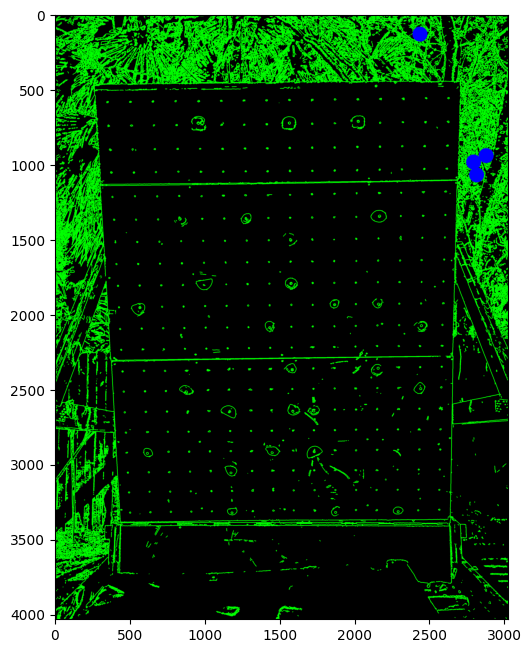

In [13]:
img_corners = np.array(img_contours, dtype=np.uint8)
gray = cv.cvtColor(img_corners, cv.COLOR_BGR2GRAY)
canny = cv.Canny(gray, 120, 255, 1)
corners = cv.goodFeaturesToTrack(canny,4,0.5,50)

for corner in corners:
    x,y = corner.ravel()
    cv.circle(img_corners,(x,y),50,(0,0,255),-1)

print(corners)
    
plt.imshow(img_corners)

## Brute force identify corners of wall

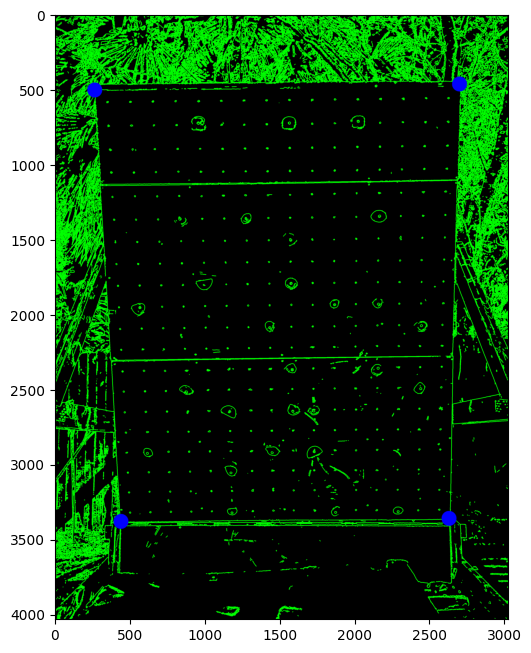

In [14]:
img_corners_bf = np.array(img_contours, dtype=np.uint8)

# ul, ur, ll, lr
bf_corners1 = np.array([
    [[265, 500]],
    [[2700, 460]],
    [[440, 3380]],
    [[2630, 3360]],
])
bf_corners = bf_corners1
for corner in bf_corners:
    x,y = corner.ravel()
    cv.circle(img_corners_bf,(x,y),50,(0,0,255),-1)
    
plt.imshow(img_corners_bf)

## Straighten image (https://stackoverflow.com/questions/41995916/opencv-straighten-an-image-with-python)

[[ 265  500]
 [2700  460]
 [ 440 3380]
 [2630 3360]]
2700
3380
(4032, 3024, 3)


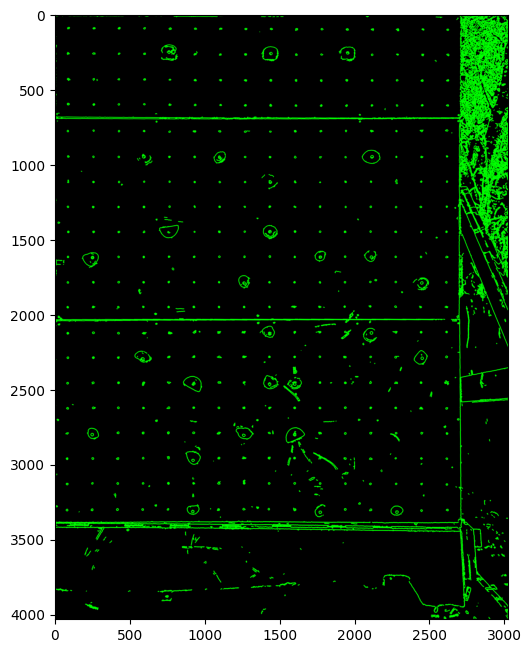

In [15]:
#---- 4 corner points of the bounding box
pts_src = np.array([pt.ravel() for pt in bf_corners])
print(pts_src)

#---- 4 corner points of the black image you want to impose it on
dx = pts_src[1][0]
print(dx)
dy = pts_src[2][1]
print(dy)
pts_dst = np.array([[0.0,0.0], [dx,0.0], [0.0,dy],[dx, dy]])

#---- forming the black image of specific size
im_dst = np.zeros(img_contours.shape, np.uint8)

#---- Framing the homography matrix
h, status = cv.findHomography(pts_src, pts_dst)

#---- transforming the image bound in the rectangle to straighten
im_out = cv.warpPerspective(img_contours, h, (im_dst.shape[1],im_dst.shape[0]))
# cv2.imwrite("im_out.jpg", im_out)

plt.imshow(im_out)

print(im_out.shape)

## Crop image

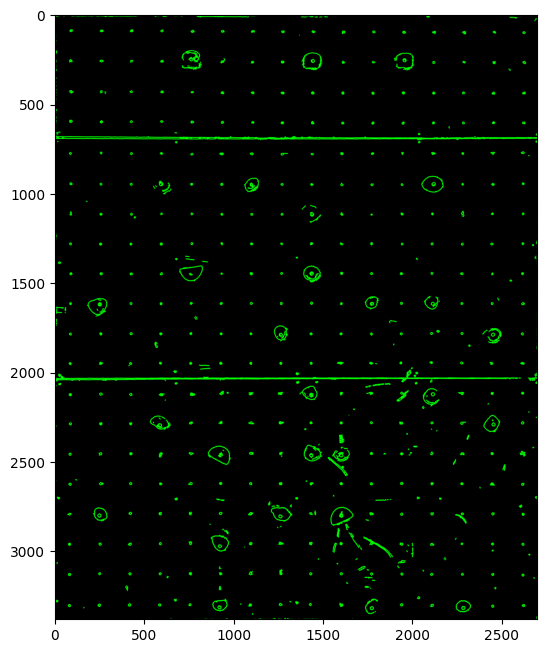

In [16]:
crop_img = im_out[:dy, :dx]
plt.imshow(crop_img)

## Transform/crop original image based on corners of wall

[[ 265  500]
 [2700  460]
 [ 440 3380]
 [2630 3360]]


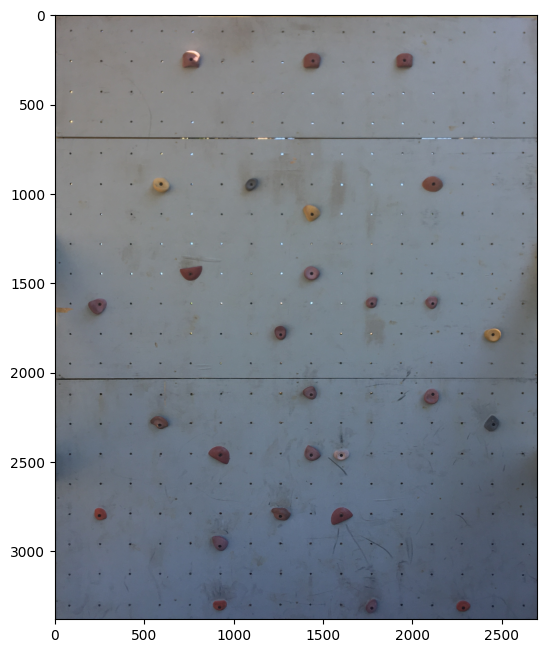

In [17]:
#---- 4 corner points of the bounding box
pts_src = np.array([pt.ravel() for pt in bf_corners])
print(pts_src)

#---- 4 corner points of the black image you want to impose it on
dx = pts_src[1][0]
dy = pts_src[2][1]
pts_dst = np.array([[0.0,0.0], [dx,0.0], [0.0,dy],[dx, dy]])

#---- forming the black image of specific size
im_dst = np.zeros(RGB_img.shape, np.uint8)

#---- Framing the homography matrix
h, status = cv.findHomography(pts_src, pts_dst)

#---- transforming the image bound in the rectangle to straighten
orig_warped = cv.warpPerspective(RGB_img, h, (im_dst.shape[1],im_dst.shape[0]))
crop_orig = orig_warped[:dy, :dx]

plt.imshow(crop_orig)

---

# Detect corners of wall by color

## Explore hsv vs rgb colors, pick appropriate color for corner circles

(14, 255, 255)


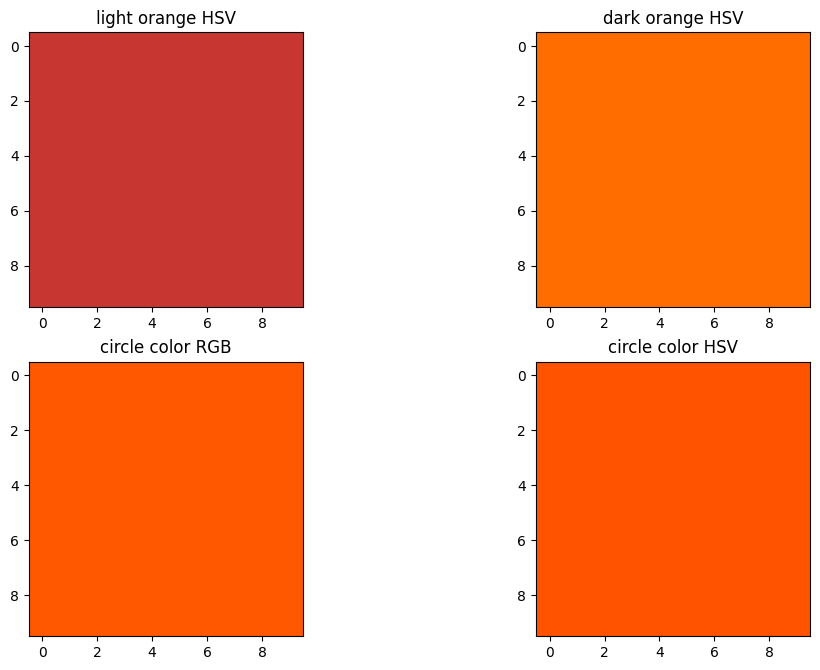

In [19]:
def show_color(color, is_hsv=True, title=""):
    square = np.full((10, 10, 3), color, dtype=np.uint8) / 255.0 
    if is_hsv:
        plt.imshow(hsv_to_rgb(square))
    else:
        plt.imshow(square)
    plt.title(title)

light_or_rgb = (255,88,0)

def rgb_to_hsv(color):
    # colorsys takes args in range 0,1 for each param, scale accordingly
    rgb = tuple([i / 255. for i in color])
    hsv = colorsys.rgb_to_hsv(*rgb)
    hsv = tuple([int(i * 255) for i in hsv])
    return hsv

light_or_hsv = rgb_to_hsv(light_or_rgb)
print(light_or_hsv)

light_orange = (1, 190, 200) # hsv
dark_orange = (18, 255, 255) # hsv

plt.subplot(2,2,1)
show_color(light_orange, title="light orange HSV")
plt.subplot(2,2,2)
show_color(dark_orange, title="dark orange HSV")
plt.subplot(2,2,3)
show_color(light_or_rgb, is_hsv=False, title="circle color RGB")
plt.subplot(2,2,4)
show_color(light_or_hsv, title="circle color HSV")
plt.show()

## Load raw wall img and add circles at corners

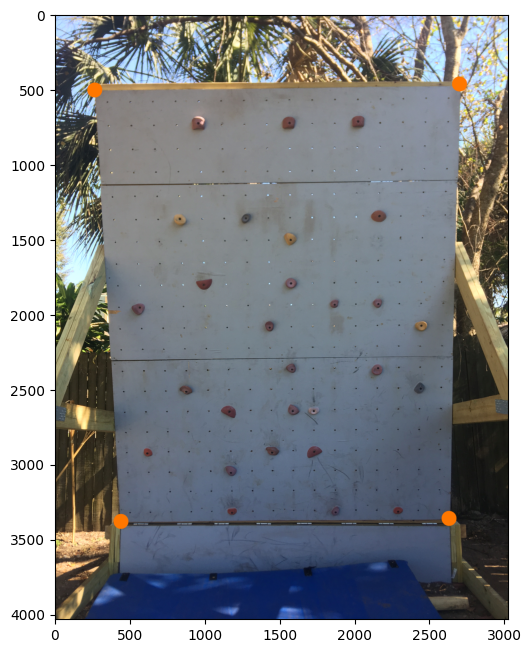

In [20]:
path = 'wall_pics/wall1.png'
raw = cv.imread(path, cv.IMREAD_UNCHANGED)
# Convert BGR to HSV
hsv = cv.cvtColor(raw, cv.COLOR_BGR2HSV)

for corner in bf_corners:
    x,y = corner.ravel()
    cv.circle(hsv,(x,y),50,light_or_hsv,-1)

raw_w_circ = cv.cvtColor(hsv, cv.COLOR_HSV2RGB)
plt.imshow(raw_w_circ)

## Filter img by color (https://realpython.com/python-opencv-color-spaces/)

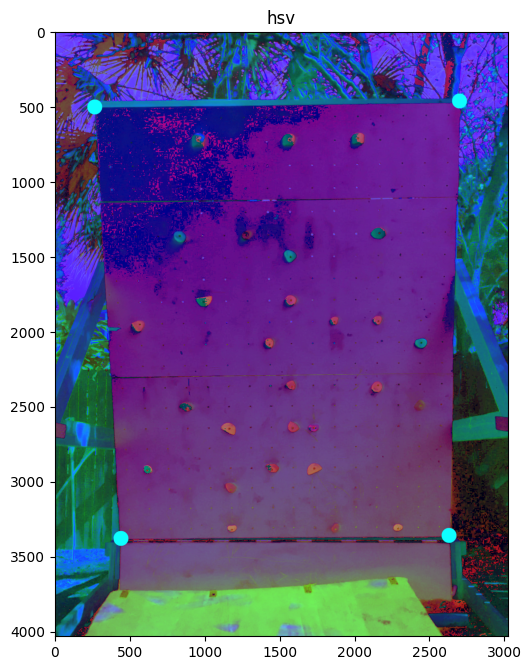

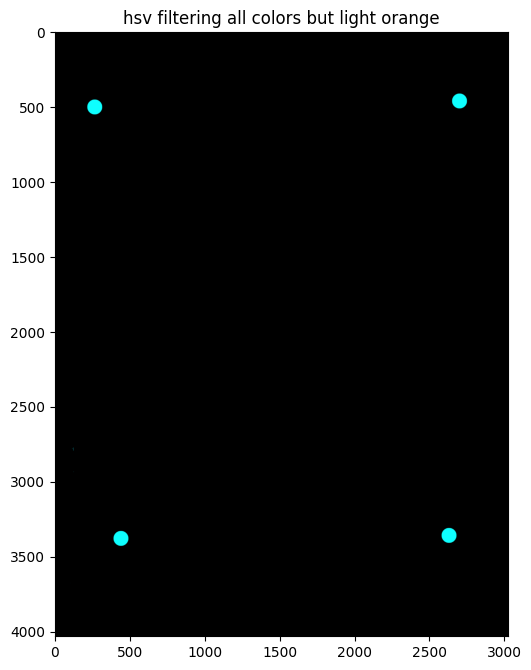

In [21]:
plt.imshow(hsv)
plt.title("hsv")
plt.show()

# Threshold the HSV image to get only orange colors
mask = cv.inRange(hsv, light_orange, dark_orange)
result = cv.bitwise_and(hsv, hsv, mask=mask)
plt.imshow(result)
plt.title("hsv filtering all colors but light orange")
plt.show()

## Get centroid of circles at corners of wall (https://www.pyimagesearch.com/2014/07/21/detecting-circles-images-using-opencv-hough-circles/)

[[ 268  500   53]
 [ 440 3376   52]
 [2626 3358   53]
 [2698  464   46]]


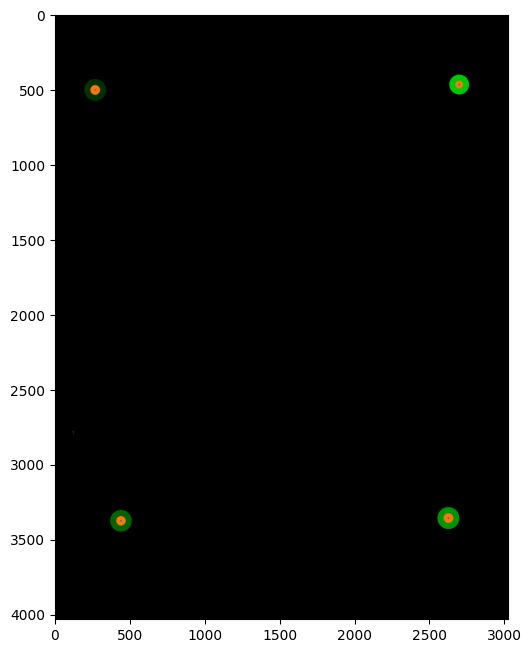

In [22]:
# convert the image to grayscale
bgr = cv.cvtColor(result, cv.COLOR_HSV2BGR)
output = cv.cvtColor(bgr, cv.COLOR_BGR2RGB)
gray = cv.cvtColor(bgr, cv.COLOR_BGR2GRAY)

# squeeze to remove single dimensional nested list
circles = np.squeeze(cv.HoughCircles(gray, cv.HOUGH_GRADIENT, 3, 100))

# ensure at least some circles were found
if circles is not None:
    # sort by first column as keys
    circles = circles[circles[:,0].argsort()]
    
    # convert the (x, y) coordinates and radius of the circles to integers
    circles = np.round(circles).astype("int")
    
    print(circles)
    
    sec = 50
    # loop over the (x, y) coordinates and radius of the circles
    for (x, y, r) in circles:
        # draw the circle in the output image, then draw a rectangle
        # corresponding to the center of the circle
        cv.circle(output, (x, y), r, (0, sec, 0), 40)
        sec += 50
        cv.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
    # show the output image
    
    plt.imshow(output)
    plt.show()
else:
    print("circles is None")

## Transform raw_w_circ and img_contours based on detected centroids of circs

In [23]:
## brute force pts_src
# [[ 265  500]
#  [2700  460]
#  [ 440 3380]
#  [2640 3380]]

## detected pts_src
# [[ 268  500]
#  [ 440 3376]
#  [2638 3376]
#  [2698  464]]

## constructed pts_dest
# [[   0.    0.]
#  [   0. 3380.]
#  [2700.    0.]
#  [2700. 3380.]]

## Make pts_src align with pts_dest
note: this is hardcoded and may not work for other images: check 

In [24]:
#---- 4 corner points of the bounding box
pts_src = np.array([pt[:2] for pt in circles])
pts_src[[1,3]] = pts_src[[3,1]]
pts_src[[2,3]] = pts_src[[3,2]]

#---- 4 corner points of the black image you want to impose it on
dx = pts_src[1][0]
dy = pts_src[2][1]
pts_dst = np.array([[0.0,0.0], [dx,0.0], [0.0,dy], [dx, dy]])

#---- forming the black image of specific size
im_dst = np.zeros(raw.shape, np.uint8)

#---- Framing the homography matrix
h, status = cv.findHomography(pts_src, pts_dst)

#---- transforming raw_w_circ bound in the rectangle to straighten
orig_warped = cv.warpPerspective(raw_w_circ, h, (im_dst.shape[1],im_dst.shape[0]))
crop_orig = orig_warped[:dy, :dx]

#---- transforming img_contours bound in the rectangle to straighten
contours_warped = cv.warpPerspective(img_contours, h, (im_dst.shape[1],im_dst.shape[0]))
crop_contours = contours_warped[:dy, :dx]

print(crop_orig.shape)
print(crop_contours.shape)

(3376, 2698, 3)
(3376, 2698, 3)


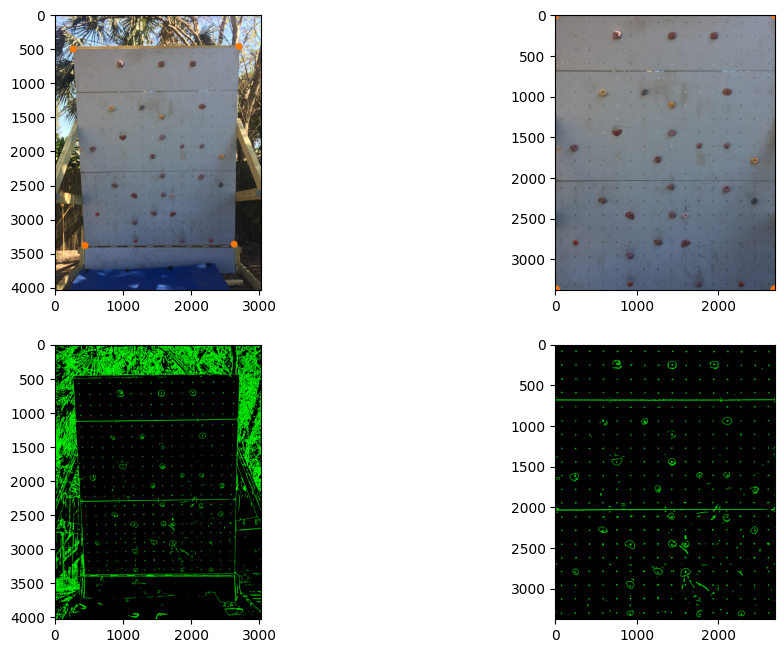

In [25]:
plt.subplot(2,2,1)
plt.imshow(raw_w_circ)
plt.subplot(2,2,2)
plt.imshow(crop_orig)
plt.subplot(2,2,3)
plt.imshow(img_contours)
plt.subplot(2,2,4)
plt.imshow(crop_contours)

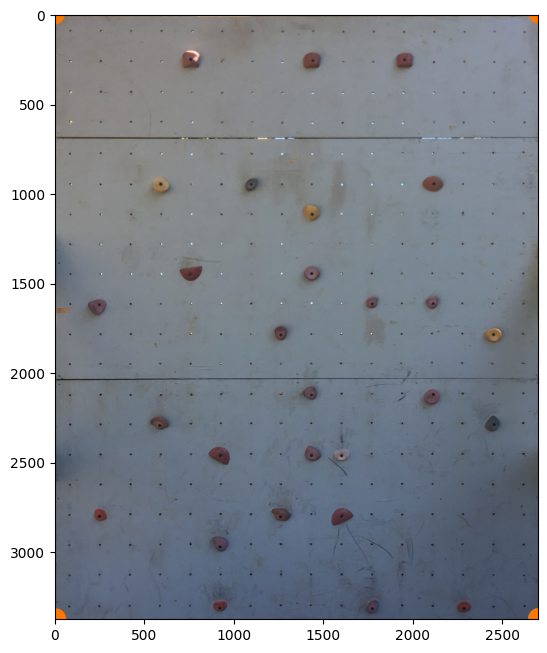

In [26]:
plt.imshow(crop_orig)

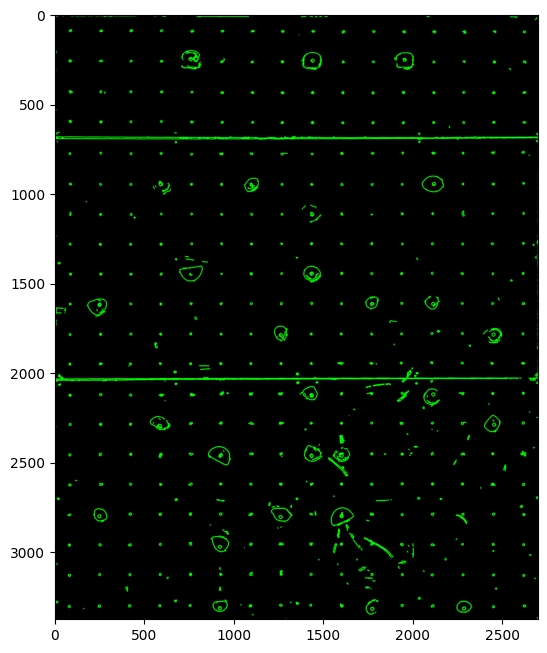

In [27]:
plt.imshow(crop_contours)

---
# Calculate coordinates of holes on wall

## Reduce img dimension to a standard size for extracting holds

raw shape:  (3376, 2698, 3)
contours shape:  (3376, 2698, 3)
raw resized shape:  (1200, 900, 3)
contours resized shape:  (1200, 900, 3)
(1200, 900, 3)


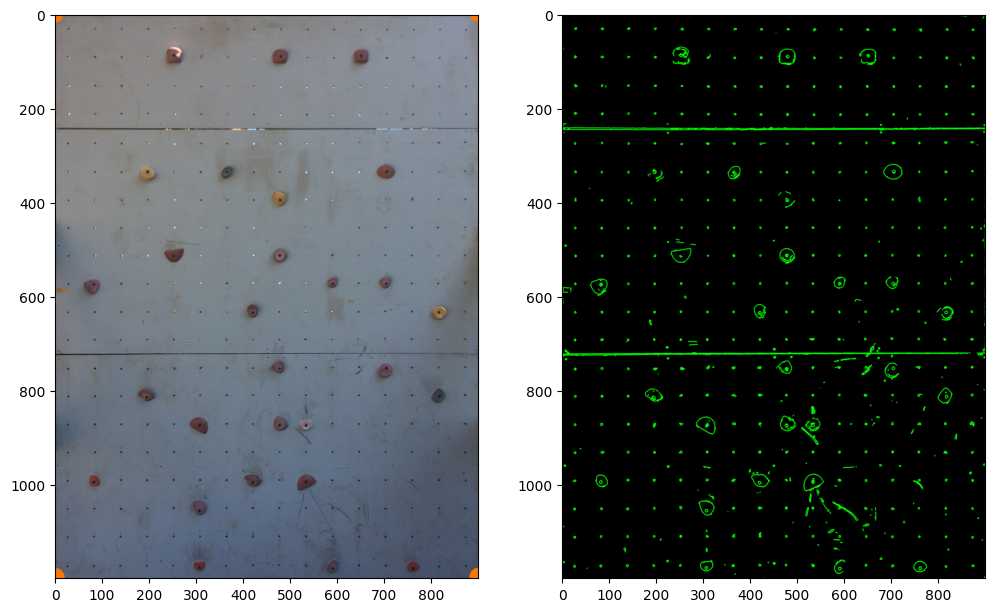

In [80]:
print("raw shape: ", crop_orig.shape)
print("contours shape: ", crop_contours.shape)

def resize_img(orig, width, height, return_RGB=False):
    # open image in RGB mode
    im = Image.fromarray(orig)

    resized = im.resize((width,height))
    open_cv_resized = np.array(resized, dtype=np.uint8)
    
    if return_RGB:
        return open_cv_resized
    
    # convert RGB to BGR
    return open_cv_resized[:, :, ::-1].copy()
    
height = 1200
width = 900

resized_orig = resize_img(crop_orig, width, height, return_RGB=True)
resized_contours = resize_img(crop_contours, width, height)

print("raw resized shape: ", resized_orig.shape)
print("contours resized shape: ", resized_contours.shape)

print(img.shape)

plt.subplot(1,2,1)
plt.imshow(resized_orig)
plt.subplot(1,2,2)
plt.imshow(resized_contours)

## Calculate coordinates in inches

In [29]:
rows = 20
cols = 16
hole_coords_in = [[None for i in range(cols)] for j in range(rows)] # origin is top left of image

x_pos = 3
# set coordinate vals in inches
for row in range(rows):
    y_pos = 3
    for col in range(cols):
        hole_coords_in[row][col] = (x_pos,y_pos)
        y_pos += 6
    x_pos += 6

In [30]:
# for row in hole_coords_in:
#     print(row)

## Calculate conversion from inches to pixels

In [31]:
width_px = width
width_in = 8 * 12 # 8 ft across
height_px = height
height_in = 10 * 12 # 10 ft across
## convert feet to pixels
width_in_per_px = width_px / width_in
height_in_per_px = height_px / height_in

print("width_in_per_px: ", width_in_per_px, "height_in_per_px: ", height_in_per_px)

width_in_per_px:  9.375 height_in_per_px:  10.0


## Calculate coordinates in pixels

In [32]:
# hole_coords_px = [[row*height_in_per_px, col*width_in_per_px] for i,j in hole_coords]
hole_coords_px = [[None for i in range(cols)] for j in range(rows)]
for i in range(rows):
    for j in range(cols):
        row, col = hole_coords_in[i][j]
        hole_coords_px[i][j] = (int(row * height_in_per_px), int(col * width_in_per_px))

In [33]:
# for row in hole_coords_px:
#     print(row)

## Create "ideal" wall image

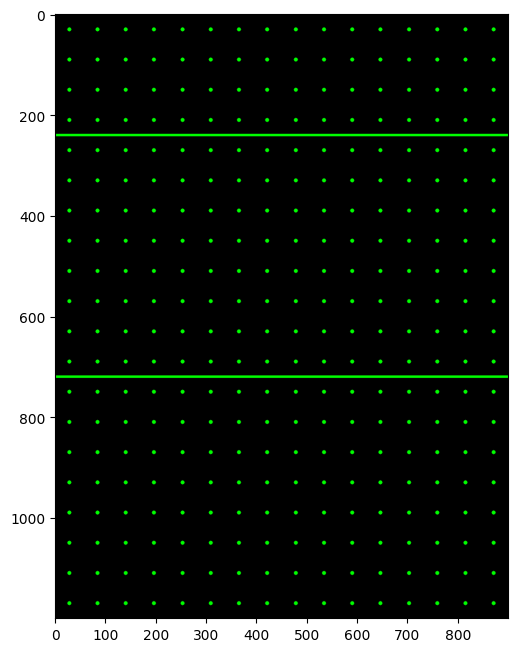

In [128]:
ideal_wall = np.zeros(resized_contours.shape, dtype=np.uint8)
r = 4

# draw circles for tnut holes
for i in range(rows):
    for j in range(cols):
        x, y = hole_coords_px[i][j]
        cv.circle(ideal_wall, (y, x), r, (0, 255, 0), -1)

# draw lines separating pieces of plywood
lines_in = [24, 72]
lines_px = [int(i * height_in_per_px) for i in lines_in]
for line in lines_px:
    start_point = (0, line)
    end_point = (width, line)
    color = (0, 255, 0)
    thickness = 3
    cv.line(ideal_wall, start_point, end_point, color, thickness)
        
plt.imshow(ideal_wall)

### NOTE: (0,0) is top left of img; update climbr to reflect this same relationship. also, need to correlate indices of type (1,1) with hole_coords of form [12,12]. could map every 6in to one increment
### SOLUTION: Just use (i,j) of indices to index the hole_coords_px

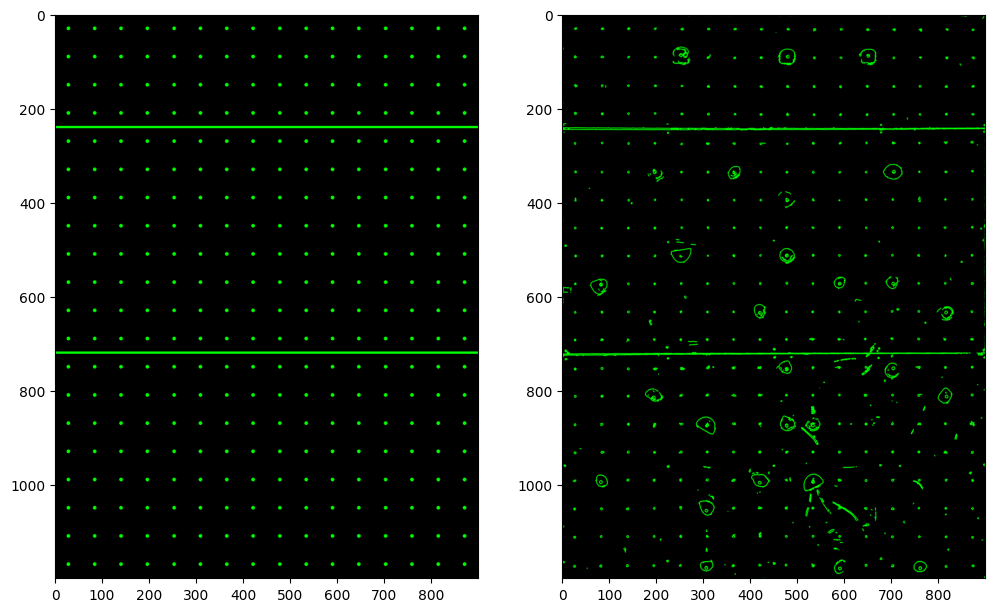

In [129]:
plt.subplot(1,2,1)
plt.imshow(ideal_wall)
plt.subplot(1,2,2)
plt.imshow(resized_contours)

---
# Try masking out irrelevant info from the contours image

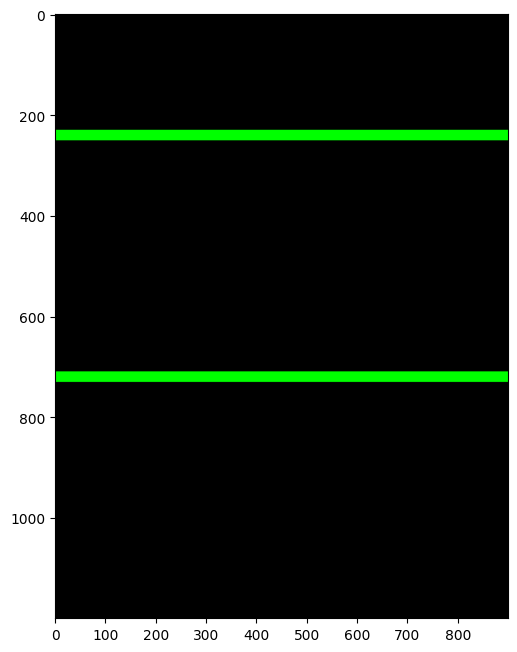

In [130]:
edges = np.zeros(resized_contours.shape, dtype=np.uint8)

# draw lines separating pieces of plywood
lines_in = [24, 72]
lines_px = [int(i * height_in_per_px) for i in lines_in]

color = (0, 255, 0)
thickness = 20

for line in lines_px:
    start_point = (0, line)
    end_point = (width, line)
    cv.line(edges, start_point, end_point, color, thickness)
        
plt.imshow(edges)

In [131]:
# def mask_img(img, mask):
#     if len(img.shape) == 3 and len(mask.shape) != 3:
#         new_image = img * (mask[:,:,None].astype(img.dtype))
#     # Case #2 - Both images are colour or grayscale
#     elif (len(img.shape) == 3 and len(mask.shape) == 3) or \
#        (len(img.shape) == 1 and len(mask.shape) == 1):
#         new_image = img * (mask.astype(img.dtype))
#     # Otherwise, we can't do this
#     else:
#         raise Exception("Incompatible input and mask dimensions")
#     return new_image

# res = mask_img(res_con_gray, mask)

# mask = cv.bitwise_not(mask)

(1200, 900)


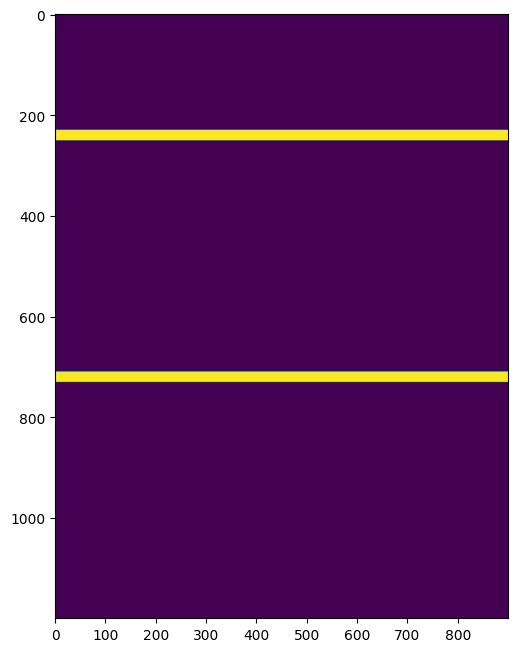

In [133]:
mask = np.array(edges[:,:], dtype=np.uint8)
mask = cv.cvtColor(mask, cv.COLOR_BGR2GRAY)

res_con_gray = cv.cvtColor(resized_contours, cv.COLOR_BGR2GRAY)
print(res_con_gray.shape)
plt.imshow(res_con_gray)

plt.imshow(mask)


(1200, 900)


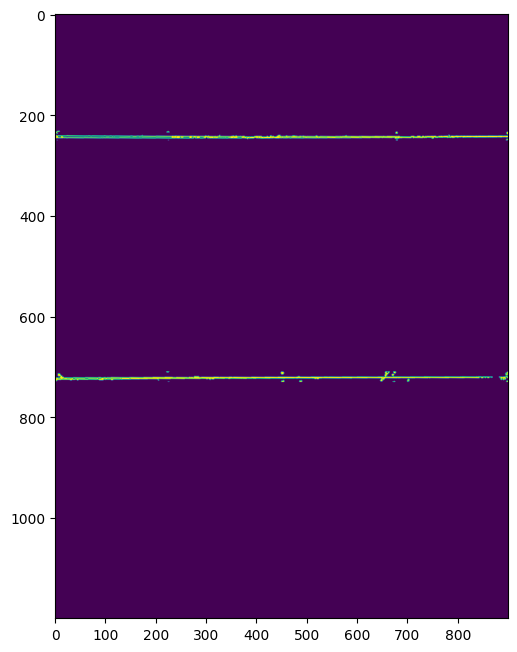

In [134]:
res = cv.bitwise_and(res_con_gray,res_con_gray,mask=mask)
print(res.shape)
plt.imshow(res)

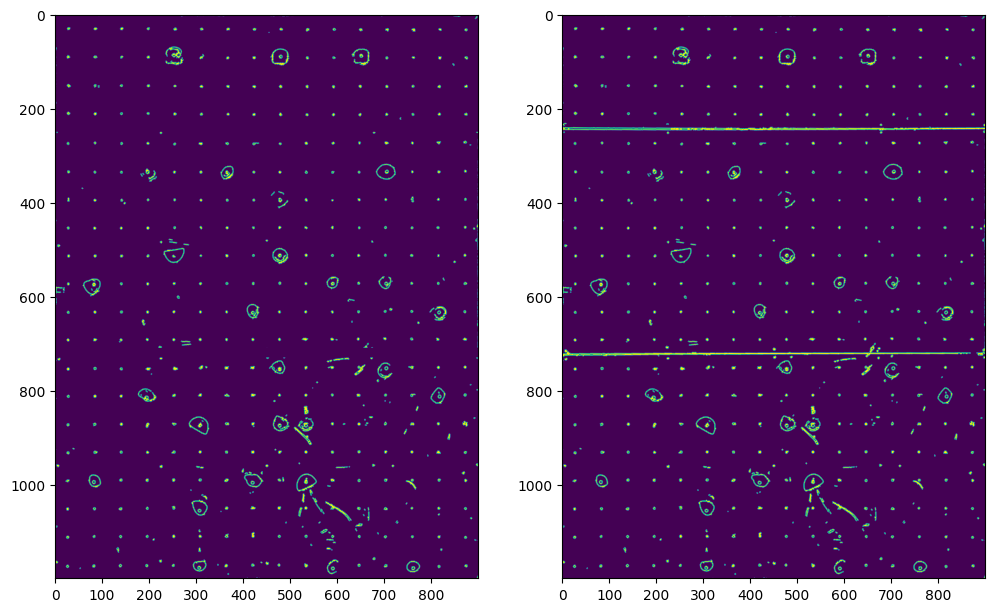

In [135]:
fewer_edges = res_con_gray - res

plt.subplot(1,2,1)
plt.imshow(fewer_edges)
plt.subplot(1,2,2)
plt.imshow(res_con_gray)

## Remove tnut holes

In [ ]:
r = 10
th = -1 # filled circle

# draw circles for tnut holes
for i in range(rows):
    for j in range(cols):
        x, y = hole_coords_px[i][j]
        cv.circle(usable_info, (y, x), r, (0, 255, 0), -1)

## Hold detection code from Neural Climb by scsukas8

In [88]:
# def buildDetector(minArea = 25):
#     # Setup SimpleBlobDetector parameters.
#     params = cv.SimpleBlobDetector_Params()

#     # Change thresholds
#     params.minThreshold = 0
#     params.maxThreshold = 255


#     # Filter by Area.
#     params.filterByArea = True
#     params.minArea = minArea

#     # Filter by Circularity
#     params.filterByCircularity = False
#     params.minCircularity = 0.1

#     # Filter by Convexity
#     params.filterByConvexity = False
#     params.minConvexity = 0.1
        
#     # Filter by Inertia
#     params.filterByInertia = True
#     params.minInertiaRatio = 0.05

#     # Create a detector with the parameters
#     ver = (cv.__version__).split('.')
#     if int(ver[0]) < 3 :
#         detector = cv.SimpleBlobDetector(params)
#     else : 
#         detector = cv.SimpleBlobDetector_create(params)

#     return detector

In [89]:
# def findHolds(img,detector = None):
#     # Applying a gaussian blur removes some small impurities that
#     # could fool the detection algorithm. It also smooths out the
#     # color of each hold to make it more uniform.
#     img = cv.GaussianBlur(img, (5, 5), 0)

#     # Using Otsu's method, the optimal threshold for the image can be found.
#     gray = None
#     if len(img.shape) == 3:
#         gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
#     else:
#         gray = img
#     otsu, _ = cv.threshold(gray,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

#     # Applys edge detection to find the borders between the hold and the wall
#     # Otsu's threshold is intended to be used as the higher threshold with a
#     # lower:upper ratio of 1:2. L2gradient is included for more precise results.
#     edges = cv.Canny(img,otsu, otsu * 2, L2gradient = True)
#     # print(otsu)

#     # Finds the contours of the image, without retaining the hierarchy or img
#     contours, _ = cv.findContours(edges,cv.RETR_LIST,cv.CHAIN_APPROX_SIMPLE)

#     # print("contours")
#     # print(len(contours))
#     # Applies convex hulls to each contour, ensuring each contour
#     # is a closed polygon.
#     hulls = list(map(cv.convexHull,contours))
    
#     # Draws contours onto a blank canvas
#     mask = np.zeros(img.shape,np.uint8)

#     cv.drawContours(mask,hulls,-1,(255,255,255),-1)

#     plt.imshow(mask)
#     plt.title("mask")
#     plt.show()

#     if detector == None:
#         # Set up the detector with default parameters.
#         detector = buildDetector()

#     keypoints = detector.detect(mask)
#     return keypoints , hulls

In [90]:
# import math
# def draw(img, keypoints):
#     # Draw detected blobs as red circles.
#     # cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the 
#     # size of the circle corresponds to the size of blob
#     for i, key in enumerate(keypoints):
#         x = int(key.pt[0])
#         y = int(key.pt[1])

#         size = int(math.ceil(key.size)) 

#         #Finds a rectangular window in which the keypoint fits
#         br = (x + size, y + size)   
#         tl = (x - size, y - size)
#         cv.rectangle(img,tl,br,(0,0,255),2)

#     #OpenCV uses BGR format, so that'll need to be reversed for display
# #     img = img[...,::-1]

#     # Display the resulting frame
#     fig = plt.imshow(img)
#     plt.title("Image with Keypoints")
#     plt.show()

In [91]:
# detector = buildDetector(minArea = 10)

In [92]:
# holds, contours = findHolds(resized_orig, detector)

In [93]:
# img = resized_orig.copy()
# draw(img,holds)